#### Import the data

The dataset can be downloaded from the following link:
https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones


In [ ]:
# Function to load the data from file
def load_HAR_data():
    data_dir = 'path/to/file'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy')) - 1
    return (x_train, y_train), (x_test, y_test)

# Dictionary containing the labels and the associated activities
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 2: 'walking downstairs',
                     3: 'sitting', 4: 'standing', 5: 'laying'}

# Function to change integer labels to one-hot labels
def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max()+1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

# Load the data
(x_train, y_train), (x_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)

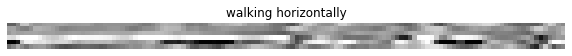

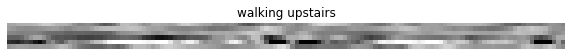

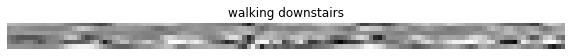

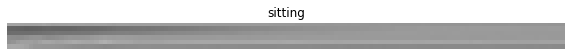

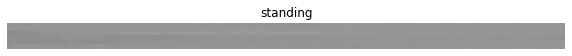

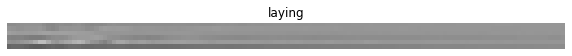

In [ ]:
# Inspect some of the data by making plots

def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()
        
make_plots(1)

#### 1D deterministic convolutional neural network
Weights are certain, this is just a standart 1D CNN model.

In [ ]:
model = Sequential([
    Conv1D(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu'),
    MaxPooling1D(pool_size=16),
    Flatten(),
    Dense(units=6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 113, 8)            776       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 342       
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


#### Probabilistic 1D convolutional neural network, with both weight and output uncertainty
Probabilistic version of the above model, uncertainities are included.

In [ ]:
divergence_fn = lambda p,q,_ : tfd.kl_divergence(q,p) / x_train.shape[0] # not biasing

model = Sequential([
                    tfpl.Convolution1DReparameterization(
                        input_shape = (128,6), filters = 32, kernel_size = 16,
                        activation = 'relu',
                        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                        kernel_divergence_fn = divergence_fn,
                        bias_prior_fn = tfpl.default_multivariate_normal_fn,
                        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                        bias_divergence_fn = divergence_fn
                    ),
                    MaxPooling1D(pool_size=(16)),
                    Flatten(),
                    tfpl.DenseReparameterization(
                        units = tfpl.OneHotCategorical.params_size(6), activation = None,
                        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                        kernel_divergence_fn = divergence_fn,
                        bias_prior_fn = tfpl.default_multivariate_normal_fn,
                        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                        bias_divergence_fn = divergence_fn                        
                    ),
                    tfpl.OneHotCategorical(6)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization_2  (None, 113, 32)           6208      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_reparameterization_2 ( (None, 6)                 2700      
_________________________________________________________________
one_hot_categorical_1 (OneHo multiple                  0         
Total params: 8,908
Trainable params: 8,908
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [ ]:
# Kullback-Leibler divergence with approximated one

def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / x_train.shape[0]

In [ ]:
def nll(y_true, y_pred): # negative log likelihood
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer=RMSprop(learning_rate=0.005),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [ ]:
model.fit(x_train, y_train_oh, epochs=100, verbose=False)
model.evaluate(x_train, y_train_oh)
model.evaluate(x_test, y_test_oh) # Not focusing on accuracy.

93/93 [==============================] - 0s 3ms/step - loss: 2.8618 - accuracy: 0.6193


[2.8617992401123047, 0.619273841381073]

#### Inspect model performance
That's the best part, the model did not have very good accuracy so that we 
can see what exactly it -does not- know. 

In [ ]:
def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[image_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


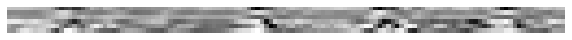

------------------------------
True activity: walking downstairs

------------------------------
Model estimated probabilities:


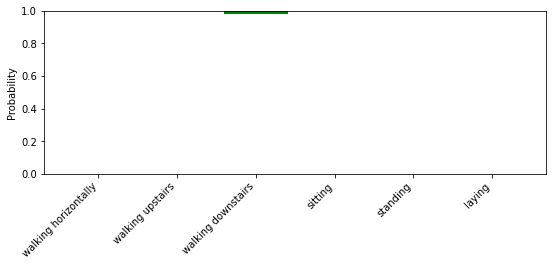

In [ ]:
analyse_model_predictions(image_num=256) # Model knows that label

------------------------------
Accelerometer data:


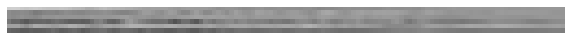

------------------------------
True activity: laying

------------------------------
Model estimated probabilities:


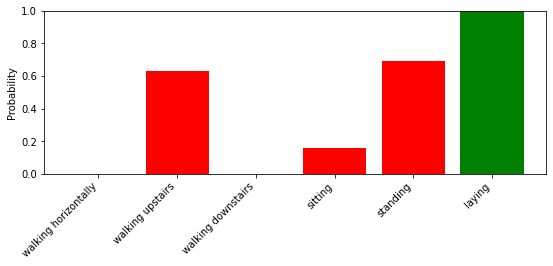

In [ ]:
analyse_model_predictions(image_num=354) # Here is the uncertainity 

------------------------------
Accelerometer data:


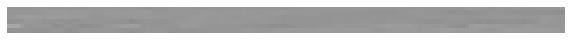

------------------------------
True activity: sitting

------------------------------
Model estimated probabilities:


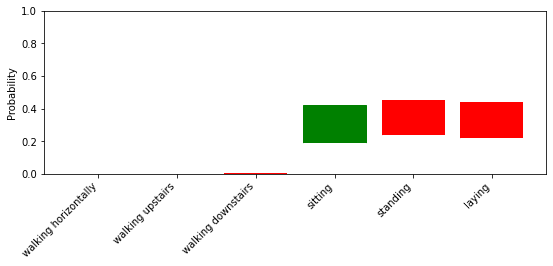

In [ ]:
analyse_model_predictions(image_num=658) # Another uncertainity
# That's basically model is telling that it is unable to identify this 3 activities
# Need more examples of this 3 labels.